# How residual shortcuts speed up learning: a minimal demonstration

The original [ResNet](https://arxiv.org/abs/1512.03385) paper by Kaiming He et al. demonstrates the effect of residual shortcuts in large convolutional neural networks with up to 110 layers and 1.7 million parameters. In this notebook we'll explore the residual shortcut in the extreme minimal setting with just one layer and only 9 parameters. Although not quite as cool as winning ImageNet, as ResNet did in 2016, I hope this approach helps to clarify residual shortcuts, what they're good for, and how to use them.

The ResNet architecture enables 110-layer convolutional networks to outperform 20-layer networks and in 2016 achieved state-of-the-art in computer vision classification tasks. The core idea is simple, a stack of 2-3 convolutional layers circumvented by a 'shortcut' connection from input to output. These 'residual blocks' are themselves stacked together to form the ResNet model, and appear often in machine learning literature, Kaggle entries and beyond.

![Resnet Block](assets/resnet_block.jpg)

 - Figure 1. A ResNet block and the ResNet architecture

## Prelims

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Motivation

He et al. start from the observation that state-of-the-art 20-layer convolutional models out performed 56-layer models on image classification tasks at that time (Fig. 2).

![Fig. 2](assets/fig1.png)

- Figure 2. "Training error (left) and test error (right) on CIFAR-10 with 20-layer and 56-layer “plain” networks. The deeper network has higher training error, and thus test error. Similar phenomena on ImageNet is presented in Fig. 4." (from original paper)

This might be surprising. Why doesn't the 56-layer model perform at least as well as the 20-layer model? We might expect that the first 20-layers of the 56-layer model could learn identical weights to the 20-layer model, then the remaining layers just need to output their input. In linear algebra the function that outputs its input is the identity function.

He et al. hypothesised that latter layers in the 56-layer model have a detrimental effect on performance because convolutional layers struggle to learn the identity function. So how might we make it easier for convolutional layers to learn the identity function? Or put another way, how might we make it easier for convolutional layers to output their input?

The ResNet approach is simple, provide a shortcut connection from the input of a layer to its output where the input is added element-wise to the output matrix. The example illustrated in Fig 1. provides a shortcut across two layers. Without a shortcut connection these layers must learn a function that maps the input to the desired output directly. 

$$z = f(x) $$  

- Equation 1.

Where $x$ is the input, $f(x)$ is some function that the layers learn, and $z$ is the output returned by that function. 

With a shortcut connection the layers learn the difference, or **the residual**, between input and output.

$$z = x + f(x) $$  
- Equation 2.

A simple change but this now means that if the optimal solution is to model the identity function then the layer learns to output a zero matrix for all inputs e.g. $f(x) = 0$. The assumption being that it is easier for a convolutional layer to learn $f(x)$ that returns zero, than it is to learn $f(x)$ that returns $x$. In the authors' words:

> "We hypothesize that it is easier to optimize the residual mapping than to optimize the original, unreferenced mapping. To the extreme, if an identity mapping were optimal, it would be easier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers." - He et al. 2015

Whilst working on my own [implementation of the ResNet paper](https://github.com/a-martyn/resnet), I found this assumption surprising. Why would it be any easier for a convolutional layer to learn a function that maps to zero than it is to learn the identity function? Let's take a closer look.

## A minimal example

Let's consider a minimal example, a single convolutional layer that outputs an array of the same shape as its input with kernel size 3, stride 1, padding 1. Our input is a tiny 3x3 grayscale image with a single channel. Let's assume that the objective is to perform the identity mapping. 

With a residual shortcut in place the layer's objective is to output a matrix of zeros irrespective of input because input is added to the layers output output via the shortcut (see equation 2.). 

![Figure 3.](assets/ZeroConv.jpg)

- Figure 3. Optimal parameters for a 3x3, stride 1 convolution that maps any input to zero.

To achieve this we would like kernel weights that return an output of zero regardless of input as the kernel is convolved left-to-right, top-to-bottom across the input. In Figure 3. imagine the blue outline at every possible position. If every weight in the kernel is zero, then every input will be multiplied by zero and so the output must be zero in every position. So the optimal kernel will be an array of zeros. Here's the equivalent in code: 

In [13]:
# Manually set the weights, there's only one 3x3 kernel in this model
weights = torch.tensor([[[[0.0,  0.0, 0.0],
                          [0.0,  0.0, 0.0],
                          [0.0,  0.0, 0.0]]]], requires_grad=True)

# Generate random input x
x = torch.tensor(np.random.random((1, 1, 3, 3)).astype(np.float32))
# Forward pass
z = F.conv2d(x, nn.Parameter(weights), stride=1, padding=1)

print(f'Input:\n {x}')
print(f'Output:\n {z}')

Input:
 tensor([[[[0.7315, 0.1468, 0.2154],
          [0.2992, 0.8183, 0.1114],
          [0.6382, 0.7877, 0.4554]]]])
Output:
 tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]], grad_fn=<ThnnConv2DBackward>)


As expected the output is zero, run the above code block multiple times to check this is the case for other inputs. Next let's consider the weights needed to perform an identity mapping In this case the only thing we change is to set the central kernel weight to `1.0`.

![Figure 4.](assets/IdentityConv.jpg)

- Figure 4. Optimal parameters for a 3x3, stride 1 convolution that maps any input to the unaltered input.

Without a shortcut connection the layers' objective becomes to output its input (see equation 1.). Intuitively the kernel selects the central pixel at each position and ignores all others. Here's a code example:

In [10]:
# Set weights to zero to ouput zero
weights = torch.tensor([[[[0.0,  0.0, 0.0],
                          [0.0,  1.0, 0.0],
                          [0.0,  0.0, 0.0]]]], requires_grad=True)
# Generate random input x
x = torch.tensor(np.random.random((1, 1, 3, 3)).astype(np.float32))
# Forward pass
z = F.conv2d(x, nn.Parameter(weights), stride=1, padding=1)

print(f'Input:\n {x}')
print(f'Output:\n {z}')

Input:
 tensor([[[[0.8361, 0.3069, 0.6524],
          [0.2145, 0.2745, 0.6489],
          [0.1664, 0.5390, 0.9452]]]])
Output:
 tensor([[[[0.8361, 0.3069, 0.6524],
          [0.2145, 0.2745, 0.6489],
          [0.1664, 0.5390, 0.9452]]]], grad_fn=<ThnnConv2DBackward>)


By setting the central kernel weight to `1.0`, the layer now performs an identity mapping - the output is the same as the input.

If He's hypothesis is correct we expect that learning the identity objective should be harder than learning the zero objective. It's still not obvious that this is the case but it turns out we can run a very minimal experiment to see for ourselves.

## Experiment 

Following from He's hypothesis that a convolutional layer with a residual shortcut can more easily learn the identity function, it follows that a convolutional layer can learn to map any input zero faster than it can learn the identity function directly.

To test this we'll create the exact same minimal model illustrated in figures 3 & 4, a single convolutional layer with a 3x3 kernel, stride 1, and padding 1. We add a ReLU activation function and initialise the 9 learn-able parameters with Kaiming He's normal initilisation method. Here's our minimal model:

In [11]:
class OneConv(nn.Module):
    """Minimal PyTorch model with single convolutional layer"""
    
    def __init__(self, channels):
        """Initialise the model"""
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.relu = nn.ReLU()
        # Initialise weights 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', 
                                        nonlinearity='relu')
    
    def forward(self, x):
        """Run a forward pass"""
        z = self.conv1(x)
        z = self.relu(z)
        return z

Next we need a training loop. We use an L1 loss function to measure the absolute difference between the target and the output of the model. With mean reduction across each pixel this is expressed as...

$$l = \frac{\sum_{i=1}^{n}|x_i - y_i|}{n}$$

- l: (scalar) loss
- n: (scalar) number of samples in dataset
- x: (array) input sample
- y: (array) target output

The rest is a vanilla backpropagation training loop using an Adam optimiser.

In [4]:
def train(X, Y, epochs):
    """
    Initialises a new model, then trains it for the given number of epochs. 
    The input samples are provide as the array `X` and the targets are 
    provided as an array of the same shape `Y`. The mean loss for each 
    epoch is returned as a list.
    """
    # Initilise model
    model = OneConv(1)
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.L1Loss()

    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        # Train model for an epoch
        for i, x in enumerate(X):
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, Y[i])
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Record mean loss for this epoch
        losses.append(running_loss / epochs)
        running_loss = 0.0
    return losses

Now we can run our experiment. We run the experiment multiple times to account for variance due to randomised inputs and weights. For each experiment we generate an array of 200 input samples `X`. For the identity setting we train a model to map X to X. In the zero setting we train another instance of our model to output zero for each input. 

We aggregate the results from each experiment and plot the mean and 95% confidence intervals. (takes ~3 minutes to run on CPU)

In [5]:
n_samples = 200
epochs = 20
experiments = 100

epochs_idx = []
losses = []
experiment = []

# Run each experiment multiple times and accumulate results
for i in range(experiments):
    # Input is random 3x3 matrix
    X = torch.tensor(np.random.random((n_samples, 1, 1, 3, 3)).astype(np.float32))
    # Target is zeros
    Y = torch.tensor(np.zeros((n_samples, 1, 1, 3, 3)).astype(np.float32))

    # Train a model to map input to output, the identity function
    losses += train(X, X, epochs)
    experiment += ['identity' for _ in range(epochs)]
    epochs_idx += list(range(epochs))
    
    # Train a model to map input to zeros
    losses += train(X, Y, epochs)
    experiment += ['zero' for _ in range(epochs)]
    epochs_idx += list(range(epochs))
 

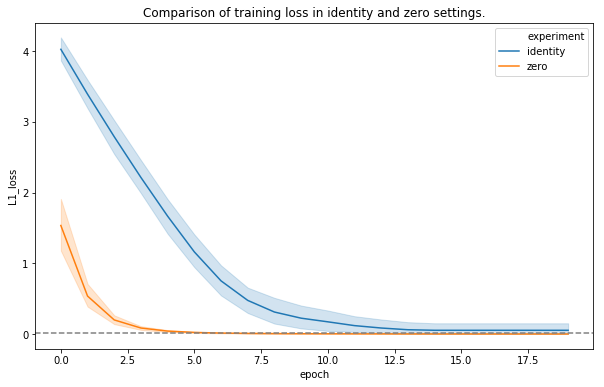

In [6]:
# Plot results with mean and 95% confidence intervals
df = pd.DataFrame({'epoch': epochs_idx, 
                   'L1_loss': losses, 
                   'experiment': experiment})
plt.figure(figsize=(10, 6))
sns.lineplot(x='epoch', y='L1_loss', hue='experiment', data=df)
plt.axhline(0.01, linestyle='--', color='gray')
plt.title('Comparison of training loss in identity and zero settings.'); 

In the zero setting the model reduces loss to below 0.01 (dashed line) in 3.5 epochs, in the identity setting the model takes 10 epochs to achieve this. The wider confidence interval indicates greater variance in the identity setting.

Even in this very minimal setting, there is evidence to support He's hypothesis. The model learns a mapping to zero almost three times faster than it learns the identity function. 

## A less minimal experiment

At this point you might not be convinced that theses observations from the extreme minimal setting extrapolate to more complex settings with larger inputs and more than one layer with more parameters. To check this I ran a similar experiment but with a full 2-layer ResNet block and 512px images as input. The code for this experiment is available [here](https://nbviewer.jupyter.org/github/a-martyn/resnet/blob/master/docs/resnet_membrane_demo.ipynb), and the results are below.

![Membrane results](assets/membrane_results.png)

The model with a residual shortcut clearly outperforms the no-shortcut model in this setting too.


## Discussion

Why do convolutional networks learn the zero mapping more easily than the identity mapping? If we can answer this question then we can understand *why* residual shortcuts improve performance. In the minimal setting there's only two practical differences I can think of:

1. **Weight configuration:** The optimal weights differ as discussed, in the zero setting all zero and in the identity setting the central weight is one and the rest zero.
2. **Target variance:** In the identity setting the target is the input which differs at each training step. In the zero setting the target is identical at every step, it is always a zero matrix.

Further investigation is needed. Intuitively, I can't see how the difference in optimal weight could be significant. My guess would be that the target variance is the cause. In the identity setting there is variance between targets at each step, and for some samples there will exist solutions that work for that specific case but that don't generalise. For example a kernel with the bottom-right value set to `1.0` performs quite well in this particular case with only one pixel in error (highlighted red).

![](assets/NonGeneralB.jpg)

- Figure 5. Example of suboptimal kernel weights for identity mapping.

Such cases could introduce variance when calculating backpropagation gradients which seems likely to impede convergence. Conversely in the zero setting there is no variance between targets, the target is always a zero matrix.

## Summary

He et al. hypothesized that residual shortcuts help convolutional layers learn identity mappings and showed that they can improve performance of convolutional networks over.

When the optimal output of a layer is close to the identity function then the residual shortcut ensures that the optimal layer activations are close to zero with reduced variance. We ran a minimal experiment to show that convolutional layers converge faster to a zero mapping with no variance in target activations, than to an identity mapping with high variance. 

Practically speaking, this suggests that if you can reduce the variance in the target activations of convolutional layers within your model then you can speed up convergence and perhaps initiate convergence in layers that otherwise would fail to do so. In other words, how can we encourage a models' activations to be more consistent across training samples? 

Next we might ask: Do these insights apply to nonlinear layers other than convolutions? In settings with other objectives and architectures is the residual the best assumption as to what layers are modeling? If not, do other shortcuts or different techniques for reducing activation variance work better?

In the next post I'll discuss the U-net, another breakthrough architecture that uses the shortcut technique. If you want to explore the full ResNet architecture then please take a look at my [PyTorch implementation](https://github.com/a-martyn/resnet). 

Thanks for reading. Any feedback, thoughts or corrections most welcome.
